## Курсовой проект

## Выполнили:


|Фио|Роль|Группа|
|---------------|----------------------|----------|
|Лагуткина Мария|Подготовка модели|М8О-109Б-23|
|Савин Александр|Подготовка данных|М8О-114Б-23|
|Сприридонов Кирилл|Сбор решения задачи|М8О-107Б-23|

Датасет [Rice type classification](https://www.kaggle.com/datasets/mssmartypants/rice-type-classification?resource=download). Требуется предсказать тип риса (Jasmine - 1, Gonen - 0), основываясь на его признаках (площадь, средняя ширина и длина, скругленность и т.д.).

In [ ]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle
from  sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.preprocessing import normalize
from math import pi
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import euclidean_distances
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, RocCurveDisplay, ConfusionMatrixDisplay

Загрузим данные:

In [ ]:
ds = pd.read_csv("data/riceClassification.csv")

Посмотрим пример данных и типы признаков:

In [ ]:
ds.head()

id  Area  MajorAxisLength  MinorAxisLength  Eccentricity  ConvexArea  \
0   1  4537        92.229316        64.012769      0.719916        4677   
1   2  2872        74.691881        51.400454      0.725553        3015   
2   3  3048        76.293164        52.043491      0.731211        3132   
3   4  3073        77.033628        51.928487      0.738639        3157   
4   5  3693        85.124785        56.374021      0.749282        3802   

   EquivDiameter    Extent  Perimeter  Roundness  AspectRation  Class  
0      76.004525  0.657536    273.085   0.764510      1.440796      1  
1      60.471018  0.713009    208.317   0.831658      1.453137      1  
2      62.296341  0.759153    210.012   0.868434      1.465950      1  
3      62.551300  0.783529    210.657   0.870203      1.483456      1  
4      68.571668  0.769375    230.332   0.874743      1.510000      1

In [ ]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18185 entries, 0 to 18184
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               18185 non-null  int64  
 1   Area             18185 non-null  int64  
 2   MajorAxisLength  18185 non-null  float64
 3   MinorAxisLength  18185 non-null  float64
 4   Eccentricity     18185 non-null  float64
 5   ConvexArea       18185 non-null  int64  
 6   EquivDiameter    18185 non-null  float64
 7   Extent           18185 non-null  float64
 8   Perimeter        18185 non-null  float64
 9   Roundness        18185 non-null  float64
 10  AspectRation     18185 non-null  float64
 11  Class            18185 non-null  int64  
dtypes: float64(8), int64(4)
memory usage: 1.7 MB


Все признаки в наборе - числовые.

Сразу можно убрать столбец id, так как идентификаторы не влияют на результат.

In [ ]:
ds.drop(['id'], axis=1, inplace=True)
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18185 entries, 0 to 18184
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Area             18185 non-null  int64  
 1   MajorAxisLength  18185 non-null  float64
 2   MinorAxisLength  18185 non-null  float64
 3   Eccentricity     18185 non-null  float64
 4   ConvexArea       18185 non-null  int64  
 5   EquivDiameter    18185 non-null  float64
 6   Extent           18185 non-null  float64
 7   Perimeter        18185 non-null  float64
 8   Roundness        18185 non-null  float64
 9   AspectRation     18185 non-null  float64
 10  Class            18185 non-null  int64  
dtypes: float64(8), int64(3)
memory usage: 1.5 MB


Проверим на наличие пропусков в данных:

In [ ]:
ds.isna().sum()

Area               0
MajorAxisLength    0
MinorAxisLength    0
Eccentricity       0
ConvexArea         0
EquivDiameter      0
Extent             0
Perimeter          0
Roundness          0
AspectRation       0
Class              0
dtype: int64

Пропусков в данных нет.

Теперь преобразуем все целочисленные значения к типу float.

In [ ]:
for column in ds.columns:
    if ds[column].dtype == 'int64':
        ds[column] = ds[column].apply(float)

ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18185 entries, 0 to 18184
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Area             18185 non-null  float64
 1   MajorAxisLength  18185 non-null  float64
 2   MinorAxisLength  18185 non-null  float64
 3   Eccentricity     18185 non-null  float64
 4   ConvexArea       18185 non-null  float64
 5   EquivDiameter    18185 non-null  float64
 6   Extent           18185 non-null  float64
 7   Perimeter        18185 non-null  float64
 8   Roundness        18185 non-null  float64
 9   AspectRation     18185 non-null  float64
 10  Class            18185 non-null  float64
dtypes: float64(11)
memory usage: 1.5 MB


Построим графики для каждой пары признаков. Гистограммы в ячейках на главной диагонали. Синий - тип риса Gonen, оранжевый - Jasmine:

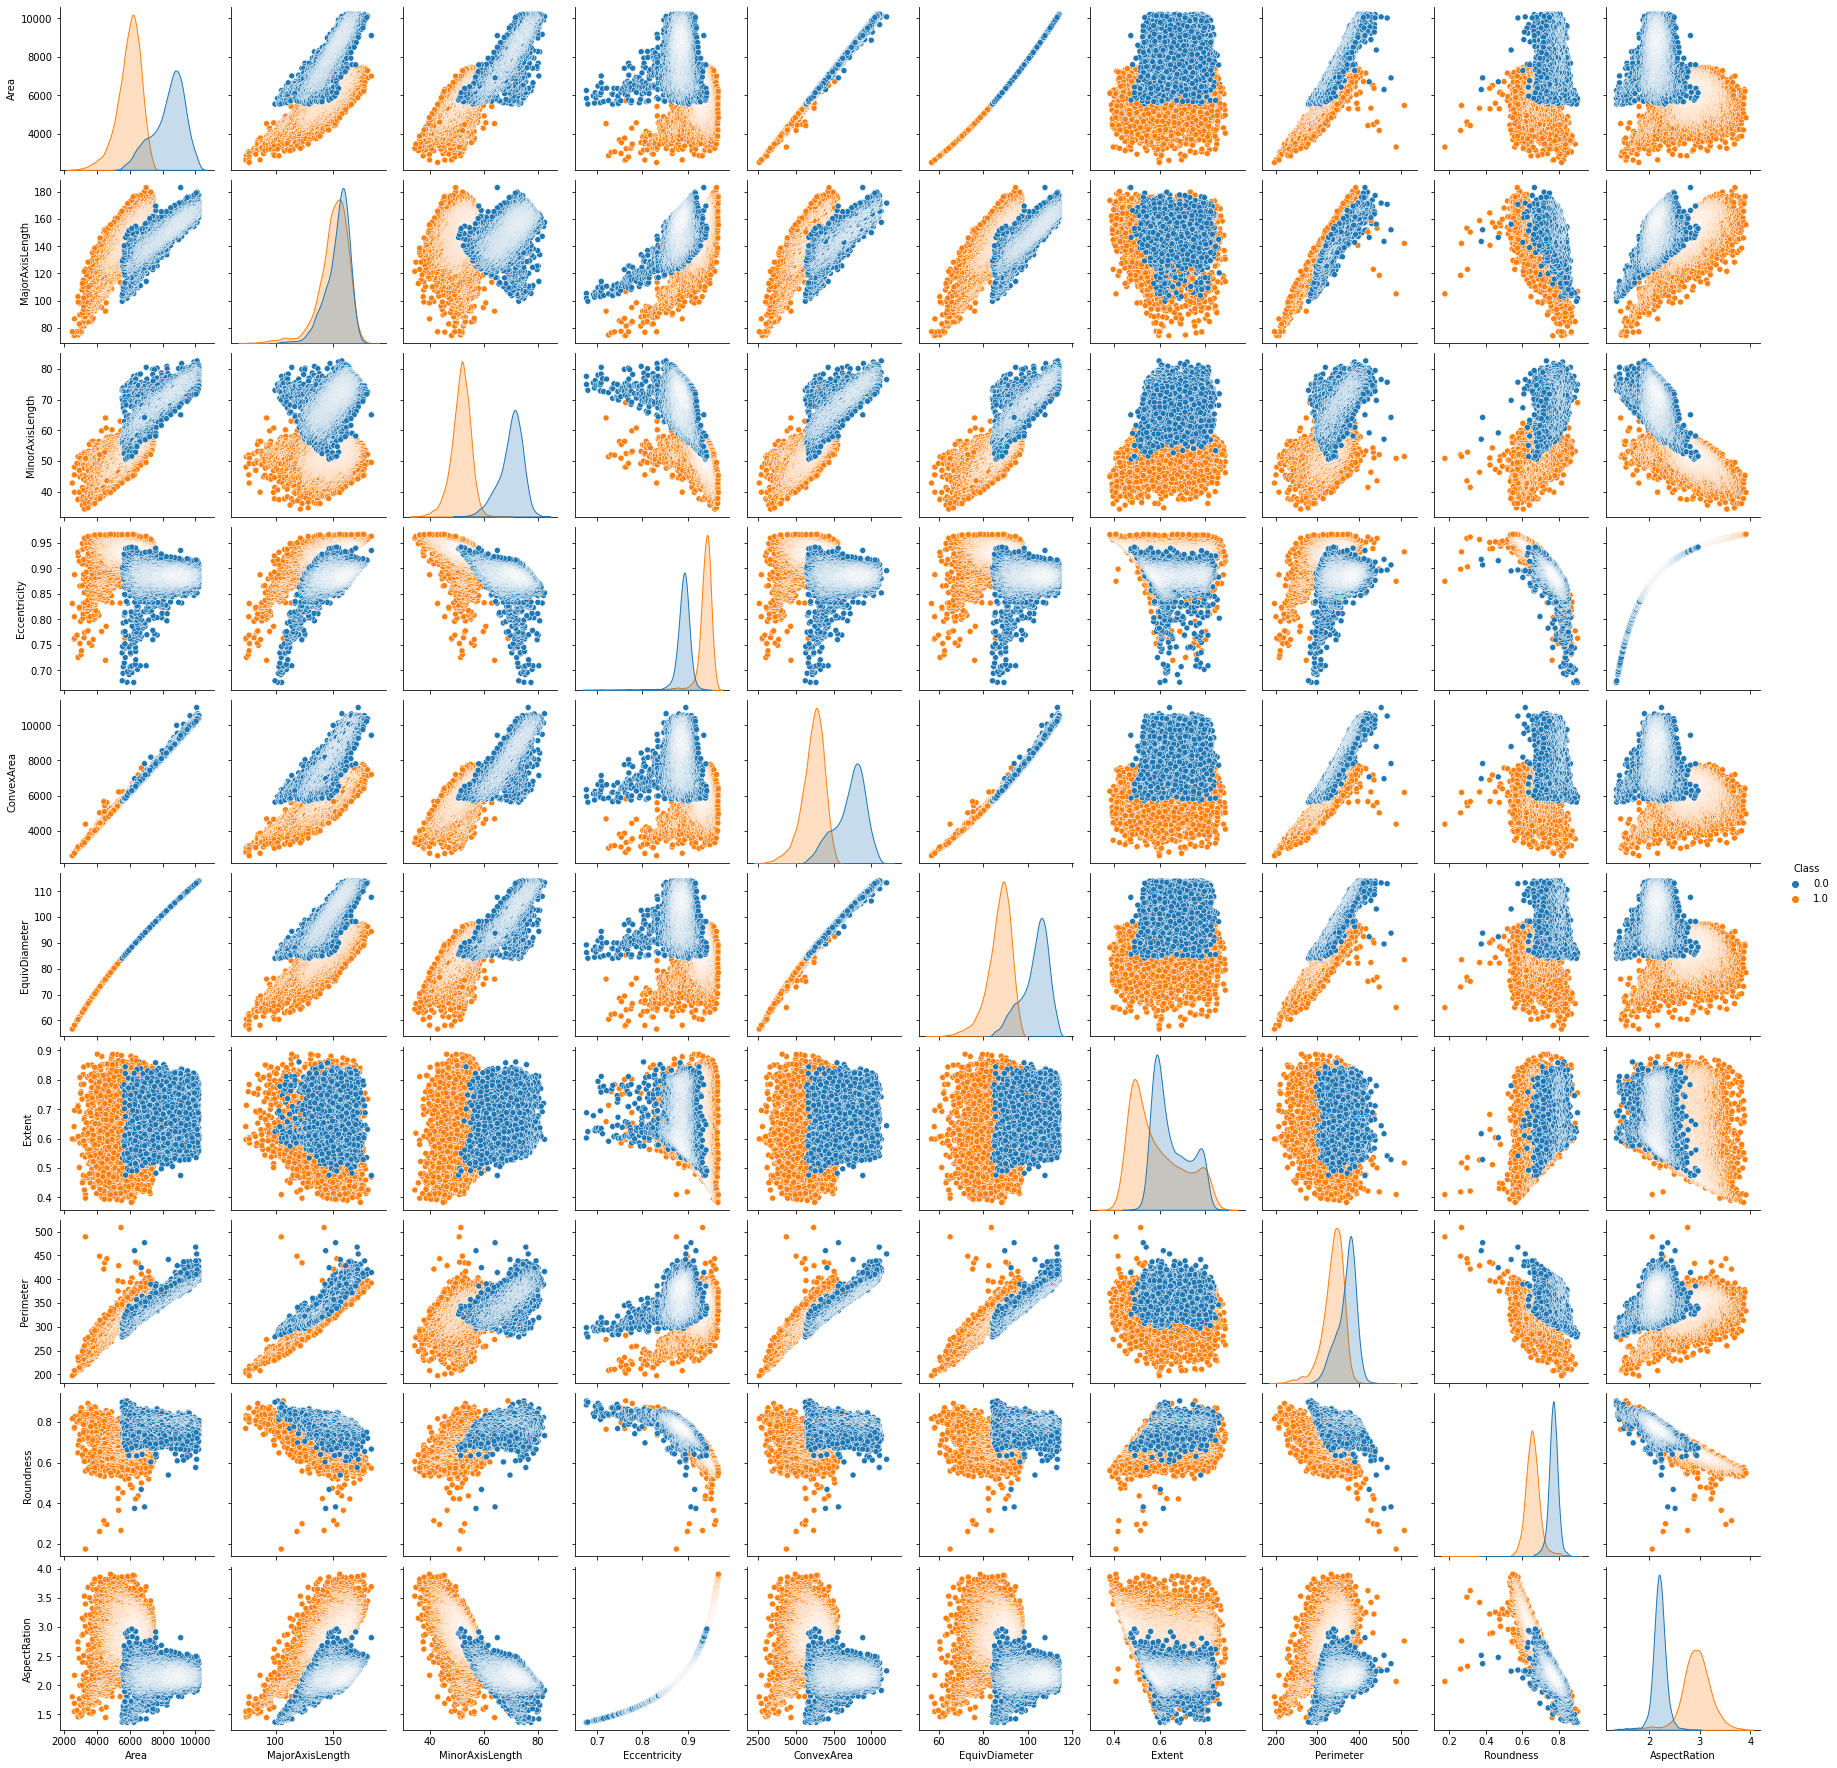

In [ ]:
sns.pairplot(data = ds, hue = "Class")
pass

Построим корреляционную матрицу для признаков:

In [ ]:
corrMatrix = ds.corr()
corrMatrix

Area  MajorAxisLength  MinorAxisLength  Eccentricity  \
Area             1.000000         0.599939         0.930215     -0.550073   
MajorAxisLength  0.599939         1.000000         0.273211      0.295717   
MinorAxisLength  0.930215         0.273211         1.000000     -0.808640   
Eccentricity    -0.550073         0.295717        -0.808640      1.000000   
ConvexArea       0.999362         0.602061         0.928992     -0.547896   
EquivDiameter    0.998158         0.618002         0.923790     -0.534688   
Extent           0.230541        -0.073549         0.308541     -0.329954   
Perimeter        0.881540         0.870178         0.674249     -0.165915   
Roundness        0.620490        -0.202566         0.834398     -0.903657   
AspectRation    -0.623979         0.240471        -0.860516      0.950301   
Class           -0.816589        -0.147741        -0.917766      0.788636   

                 ConvexArea  EquivDiameter    Extent  Perimeter  Roundness  \
Area               0.999362       0.998158  0.230541   0.881540   0.620490   
MajorAxisLength    0.602061       0.618002 -0.073549   0.870178  -0.202566   
MinorAxisLength    0.928992       0.923790  0.308541   0.674249   0.834398   
Eccentricity      -0.547896      -0.534688 -0.329954  -0.165915  -0.903657   
ConvexArea         1.000000       0.997403  0.227359   0.886987   0.610236   
EquivDiameter      0.997403       1.000000  0.225944   0.891567   0.607432   
Extent             0.227359       0.225944  1.000000   0.073227   0.366793   
Perimeter          0.886987       0.891567  0.073227   1.000000   0.186063   
Roundness          0.610236       0.607432  0.366793   0.186063   1.000000   
AspectRation      -0.621472      -0.609957 -0.350875  -0.227256  -0.947875   
Class             -0.814214      -0.809361 -0.303440  -0.533274  -0.831759   

                 AspectRation     Class  
Area                -0.623979 -0.816589  
MajorAxisLength      0.240471 -0.147741  
MinorAxisLength     -0.860516 -0.917766  
Eccentricity         0.950301  0.788636  
ConvexArea          -0.621472 -0.814214  
EquivDiameter       -0.609957 -0.809361  
Extent              -0.350875 -0.303440  
Perimeter           -0.227256 -0.533274  
Roundness           -0.947875 -0.831759  
AspectRation         1.000000  0.832563  
Class                0.832563  1.000000

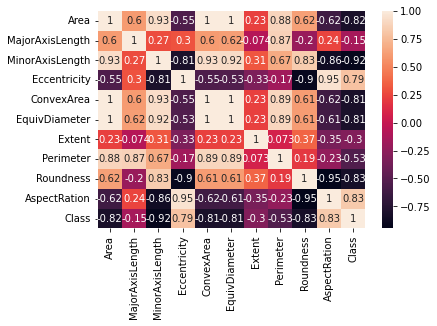

In [ ]:
sns.heatmap(corrMatrix, annot=True)
pass

Построим гистограмму для числовых признаков:

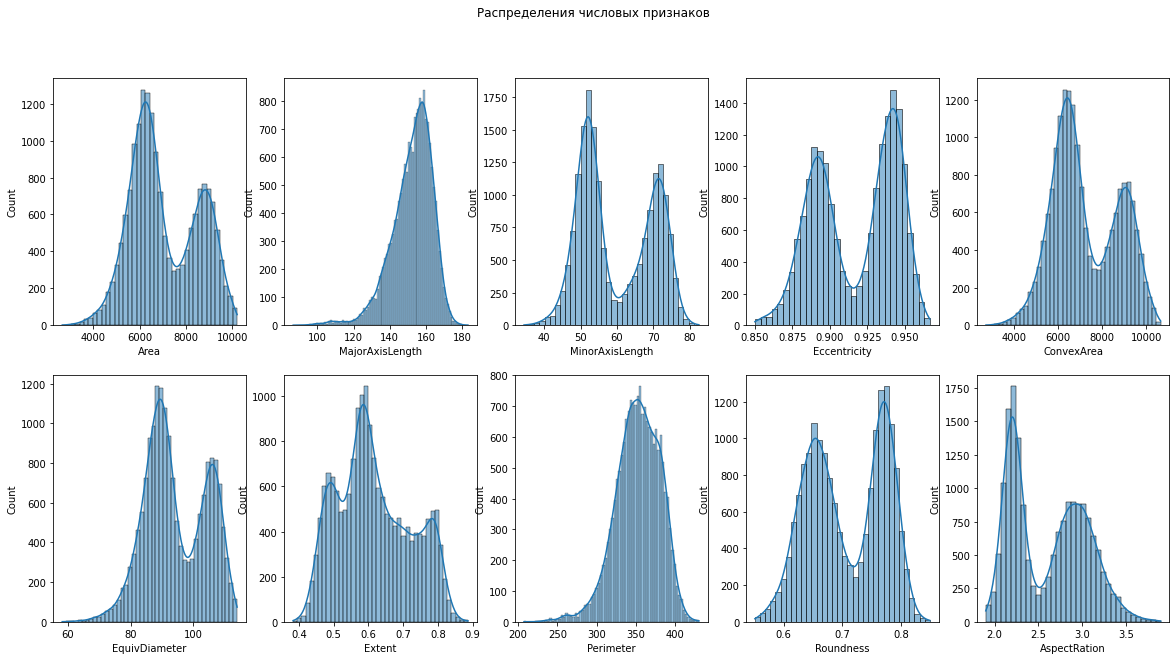

In [ ]:
def visualize(dataset):
    fig, ax = plt.subplots(2, 5, figsize = (20, 10))
    fig.suptitle('Распределения числовых признаков')
    cols = ds.columns
    for i in range(10):
        sns.histplot(ds[cols[i]], ax = ax[i // 5][i % 5], kde = True)
    pass

visualize(ds)

Есть небольшое количество выбросов у нескольких признаков.

Можно удалить все данные для Roundness < 0.55, Perimeter > 430 и Eccentricity < 0.85, MajorAxisLength < 80

In [ ]:
ds = ds.loc[ds['Roundness'] >= 0.55]
ds = ds.loc[ds['Perimeter'] <= 430]
ds = ds.loc[ds['Eccentricity'] >= 0.85]
ds = ds.loc[ds['MajorAxisLength'] >= 0.80]
ds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17850 entries, 89 to 18184
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Area             17850 non-null  float64
 1   MajorAxisLength  17850 non-null  float64
 2   MinorAxisLength  17850 non-null  float64
 3   Eccentricity     17850 non-null  float64
 4   ConvexArea       17850 non-null  float64
 5   EquivDiameter    17850 non-null  float64
 6   Extent           17850 non-null  float64
 7   Perimeter        17850 non-null  float64
 8   Roundness        17850 non-null  float64
 9   AspectRation     17850 non-null  float64
 10  Class            17850 non-null  float64
dtypes: float64(11)
memory usage: 1.6 MB


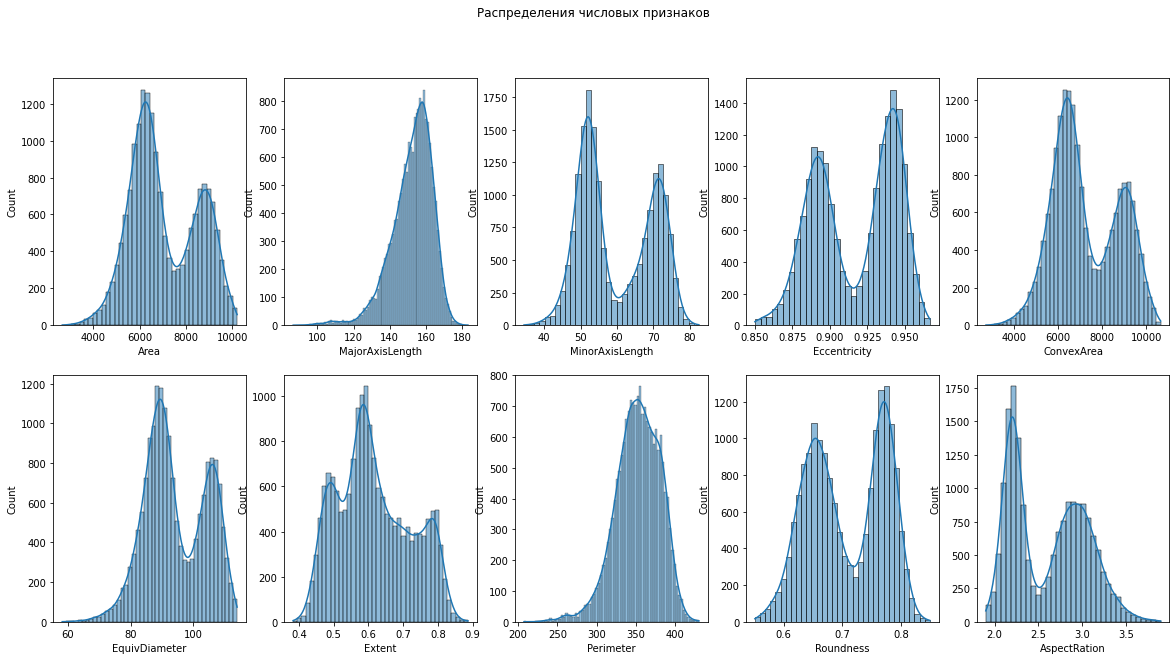

In [ ]:
visualize(ds)

Построим те же графики для обработанных данных:

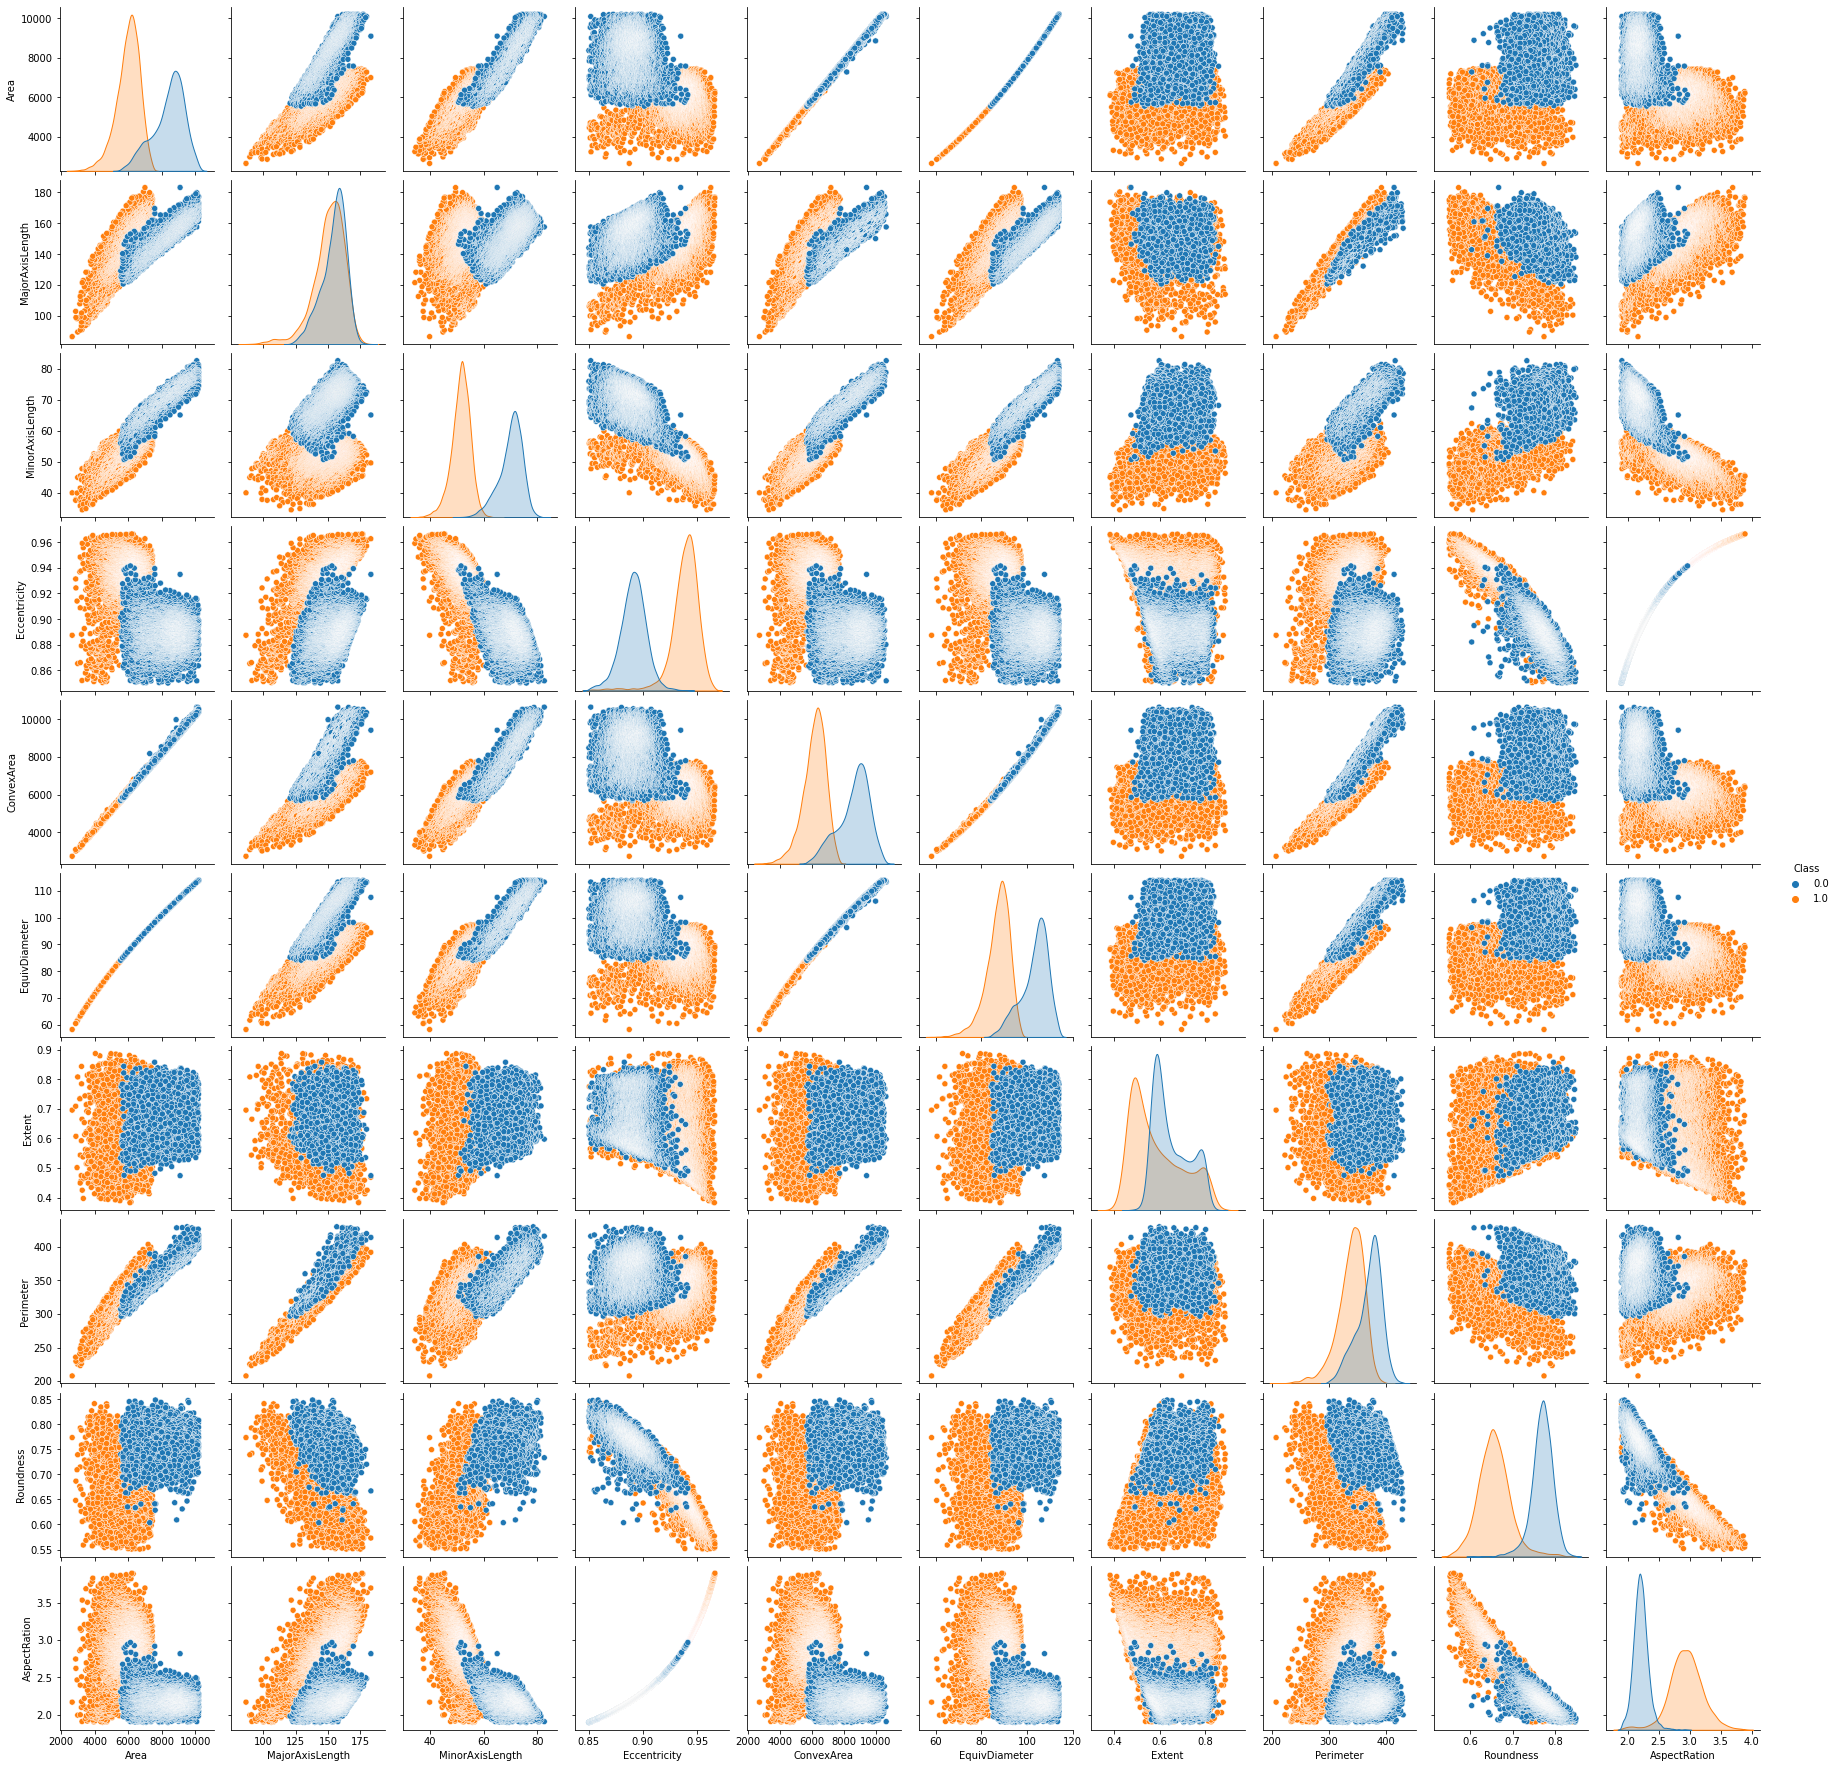

In [ ]:
sns.pairplot(data = ds, hue = "Class")
pass

In [ ]:
corrMatrix = ds.corr()
corrMatrix

Area  MajorAxisLength  MinorAxisLength  Eccentricity  \
Area             1.000000         0.603812         0.946509     -0.690926   
MajorAxisLength  0.603812         1.000000         0.321438      0.140699   
MinorAxisLength  0.946509         0.321438         1.000000     -0.884150   
Eccentricity    -0.690926         0.140699        -0.884150      1.000000   
ConvexArea       0.999464         0.605986         0.945375     -0.688615   
EquivDiameter    0.998410         0.618926         0.941972     -0.680347   
Extent           0.240312        -0.052004         0.305668     -0.340384   
Perimeter        0.895406         0.873450         0.720289     -0.332913   
Roundness        0.674885        -0.136931         0.856598     -0.952724   
AspectRation    -0.682157         0.159393        -0.877136      0.979243   
Class           -0.827021        -0.170737        -0.917902      0.874752   

                 ConvexArea  EquivDiameter    Extent  Perimeter  Roundness  \
Area               0.999464       0.998410  0.240312   0.895406   0.674885   
MajorAxisLength    0.605986       0.618926 -0.052004   0.873450  -0.136931   
MinorAxisLength    0.945375       0.941972  0.305668   0.720289   0.856598   
Eccentricity      -0.688615      -0.680347 -0.340384  -0.332913  -0.952724   
ConvexArea         1.000000       0.997792  0.237565   0.899304   0.666659   
EquivDiameter      0.997792       1.000000  0.237038   0.903931   0.665266   
Extent             0.237565       0.237038  1.000000   0.098249   0.361120   
Perimeter          0.899304       0.903931  0.098249   1.000000   0.283518   
Roundness          0.666659       0.665266  0.361120   0.283518   1.000000   
AspectRation      -0.679821      -0.672434 -0.345002  -0.316330  -0.959617   
Class             -0.824599      -0.821179 -0.302276  -0.563248  -0.859576   

                 AspectRation     Class  
Area                -0.682157 -0.827021  
MajorAxisLength      0.159393 -0.170737  
MinorAxisLength     -0.877136 -0.917902  
Eccentricity         0.979243  0.874752  
ConvexArea          -0.679821 -0.824599  
EquivDiameter       -0.672434 -0.821179  
Extent              -0.345002 -0.302276  
Perimeter           -0.316330 -0.563248  
Roundness           -0.959617 -0.859576  
AspectRation         1.000000  0.854184  
Class                0.854184  1.000000

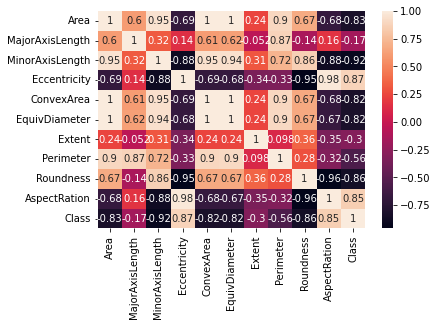

In [ ]:
sns.heatmap(corrMatrix, annot=True)
pass

Корреляционная матрица после удаления выбросов не изменилась.

Видно, что почти все признаки, кроме MajorAxisLength и Extent, очень сильно влияют на конечный результат. Также некоторые признаки довольно сильно коррелируют между собой, что может быть объяснено тем, что всё это, по сути, геометрические параметры, которые связаны между собой, т.к. контур риса обоих сортов напоминает эллипс.


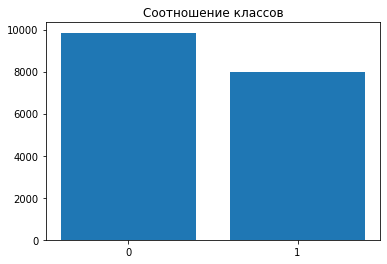

In [ ]:
indexes = [0, 1]
cnts = ds['Class'].value_counts().values

plt.title("Соотношение классов")
plt.xticks(indexes)
plt.bar(indexes, cnts)
plt.show()

В соотношении классов наблюдается небольшой дисбаланс объектов.

Данные готовы к обучению.

In [ ]:
X = ds.drop("Class", axis=1).to_numpy()
y = ds["Class"].to_numpy()

print(X.shape)
print(y.shape)

(17850, 10)
(17850,)


Данные разбиваем на обучающую и тестовую выборку, после этого нормализуем данные.

In [ ]:
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size = 0.8, random_state = 1, shuffle = True)

train_X = normalize(train_X, norm="max", axis=0)
test_X = normalize(test_X, norm="max", axis=0)

print(train_X.shape)
print(train_y.shape)

print(test_X.shape)
print(test_y.shape)

(14280, 10)
(14280,)
(3570, 10)
(3570,)


Dataloader наивная реализация

In [ ]:
def default_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    if isinstance(batch[0], (int, float)):
        return np.array(batch)
    if isinstance(batch[0], (list, tuple)):
        return tuple(default_collate(var) for var in zip(*batch))

# Наивная реализация в одном потоке
class DataLoader:
    def __init__(self, dataset, batch_size=2, collate_fn=default_collate):
        self.index = 0
        self.dataset = dataset
        self.batch_size = batch_size
        self.collate_fn = collate_fn

    # Возвращает объект для итерации
    def __iter__(self):
        self.index = 0
        return self

    # Следующий батч
    def __next__(self):
        if self.index >= len(self.dataset):
            # проверка выхода за границы
            raise StopIteration
        batch_size = min(len(self.dataset) - self.index, self.batch_size)
        return self.collate_fn([self.get() for _ in range(batch_size)])

    # Элемент по текущему индексу
    def get(self):
        item = self.dataset[self.index]
        self.index += 1
        return item

Логистическая регрессия содержит сеть, состояющую из линейного слоя, сигмиоды и функции потерь
(binary cross entropy loss, так как задача состоит в бинарной классификации).

Также есть настраиваемый параметр -- кол-во входных признаков.

Алгоритм обучения сети — стохастический градиентный спуск с постоянным шагом.

In [ ]:
class Layer:
    def forward(self, *args):
        pass

    def backward(self, *args):
        pass

class Linear(Layer):
    def __init__(self, nin, nout):
        sigma = 1.0 / np.sqrt(2.0 * nin)
        self.W = np.random.normal(0, sigma, (nout, nin))
        self.b = np.zeros((1, nout))
        self.dW = np.zeros_like(self.W)
        self.db = np.zeros_like(self.b)

    def forward(self, x):
        self.x = x
        return np.dot(x, self.W.T) + self.b

    def backward(self, dz):
        dx = np.dot(dz, self.W)
        dW = np.dot(dz.T, self.x)
        db = dz.sum(axis=0)
        self.dW = dW
        self.db = db
        return dx

    def update(self, lr):
        self.W -= lr * self.dW
        self.b -= lr * self.db

class BinaryCrossEntropy(Layer):
    def forward(self, p, y):
        y = y.reshape((y.shape[0], 1))
        self.p = p
        self.y = y
        res = y * np.log(p) + (1 - y) * np.log(1 - p)
        return -np.mean(res)

    def backward(self, loss):
        res = (self.p - self.y) / (self.p * (1 - self.p))
        return res / self.p.shape[0]

class Sigmoid(Layer):
    def forward(self, x):
        self.y = 1.0 / (1.0 + np.exp(-x))
        return self.y

    def backward(self, dy):
        return self.y * (1.0 - self.y) * dy

In [ ]:
class Net:
    def __init__(self, loss=BinaryCrossEntropy()):
        self.layers = []
        self.loss_ = loss

    def add(self, l: Layer):
        self.layers.append(l)

    def forward(self, x):
        for l in self.layers:
            x = l.forward(x)
        return x

    def backward(self, z):
        for l in self.layers[::-1]:
            z = l.backward(z)
        return z

    def update(self, lr):
        for l in self.layers:
            if 'update' in l.__dir__():
                l.update(lr)

    def get_loss_acc(self, x, y):
        p = self.forward(x)
        l = self.loss_.forward(p, y)
        pred = np.argmax(p, axis=1)
        acc = (pred == y).mean()
        return l, acc

    def train_epoch(self, train_x, train_labels, batch_size=4, lr=0.1):
        for i in range(0, len(train_x), batch_size):
            xb = train_x[i:i + batch_size]
            yb = train_labels[i:i + batch_size]

            p = self.forward(xb)
            l = self.loss_.forward(p=p, y=yb)
            dp = self.loss_.backward(loss=l)
            dx = self.backward(z=dp)
            self.update(lr)

In [ ]:
class LogisticRegression(ClassifierMixin, BaseEstimator):
    def __init__(self, epoches=1, batch_size=10, SGD_step=0.001, nin=10):
        self.epoches = epoches
        self.batch_size = batch_size
        self.SGD_step = SGD_step
        self.nin = nin
        self.Net = Net(BinaryCrossEntropy())
        self.Net.add(Linear(nin, 1))
        self.Net.add(Sigmoid())

    def fit(self, X, y):
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)

        self.X_ = X
        self.y_ = y
        self.is_fitted_ = True
        for _ in range(self.epoches):
            self.Net.train_epoch(X, y, self.batch_size, self.SGD_step)
        # Return the classifier
        return self

    def predict(self, X):
        # Check is fit had been called
        check_is_fitted(self, ['X_', 'y_'])

        # Input validation
        X = check_array(X)

        y = self.Net.forward(X)
        res = np.where(y < 0.5, 0, 1)
        return res

    def getW(self):
        return self.Net.layers[0].W

    def getb(self):
        return self.Net.layers[0].b

In [ ]:
def scores(model, X, y_true):
    y_pred = model.predict(X)
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    figure = plt.figure(figsize = (20, 5))
    matr = confusion_matrix(y_true, y_pred)
    ax = plt.subplot(1, 2, 1)
    ConfusionMatrixDisplay(matr).plot(ax = ax)
    ax = plt.subplot(1, 2, 2)
    RocCurveDisplay.from_predictions(y_true = y_true, y_pred = y_pred, name = "ROC-кривая", ax = ax)
    plt.show()

In [ ]:
train_X.shape[1]

10

In [ ]:
gscv = GridSearchCV(Pipeline([("logreg", LogisticRegression())]),
                    {"logreg__epoches" : [1, 2, 4],
                     "logreg__batch_size" : [5, 10, 20],
                     "logreg__SGD_step" : [0.01, 0.05, 0.1]})
gscv.fit(train_X, train_y)

GridSearchCV(estimator=Pipeline(steps=[('logreg', LogisticRegression())]),
             param_grid={'logreg__SGD_step': [0.01, 0.05, 0.1],
                         'logreg__batch_size': [5, 10, 20],
                         'logreg__epoches': [1, 2, 4]})

Параметры, на которых достигнута наилучшая точнось:

In [ ]:
print("params:", gscv.best_params_)
print("Acc:", gscv.best_score_)

params: {'logreg__SGD_step': 0.1, 'logreg__batch_size': 5, 'logreg__epoches': 4}
Acc: 0.9843837535014005


Accuracy: 0.9876750700280112
Recall: 0.9974372116863147
Precision: 0.980352644836272


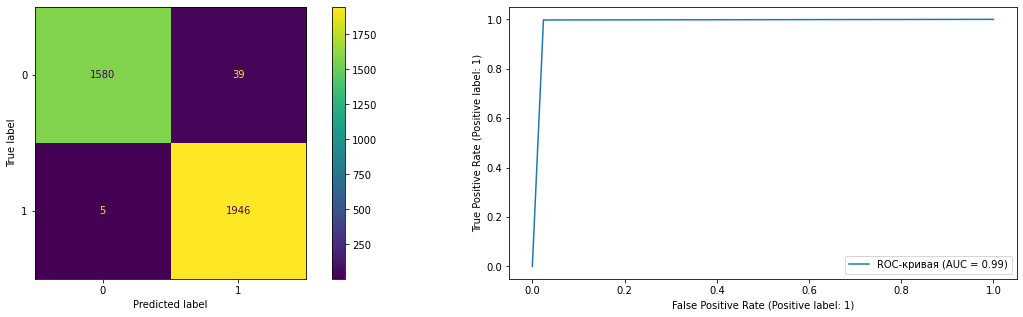

In [ ]:
logreg_best = gscv.best_estimator_
scores(logreg_best, test_X, test_y)